## UDA Assignment 3 - Crowdsourced Recommender System
Created by: Aman Bhardwaj, Blake DeLong, Apurva Harsulkar, Colby Meline, Joel Nail, and Rahul Rangarao

In [1]:
import numpy as np
import pandas as pd
import math
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from string import punctuation
import re
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /Users/joelnail/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Creating a dataframe from our scraped data

In [2]:
# creating a dataframe from the review file and dropping any reviews with NA values
reviews = pd.read_csv('Scraped_Data/final_reviews_with_names.csv')
reviews.dropna(inplace=True)
reviews.reset_index(drop=True, inplace=True)

# defining a list of English stop words to remove from our reviews
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

### Word Frequency Analysis

In [18]:
website = re.compile("(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+")  # Used to remove URLS
word_freq = {} # dictionary where we will store word frequencies

# for each review, we will first remove any URLS and convert all the text to lowercase 
# next we will tokenize the words in the review and add the count of words to our word_freq dictionary
for i in reviews.iloc[:,6]:
    text = str(i)
    urls = set(re.findall(website, text)) 
    for url in urls:
        text = text.replace(url, "")

    text = text.lower()
    text = word_tokenize(str(text))
    for word in text:
        if word not in word_freq:
            word_freq[word]=1
        else:
            word_freq[word]+=1

# creating a pandas dataframe from our word_freq dictionary and sorting from highest to lowest frequency 
word_freq_df = pd.DataFrame({"word": [i for i in word_freq.keys()], "frequency": [i for i in word_freq.values()]})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
print("word frequency calculation completed")

word frequency calculation completed


In [19]:
add_punc = ["’", "``", "'s", "''", "”", "—", "“", "amp", "nan", ",", ".", ":", "?", "—", "@", "&", ";", "!", "$", "#",\
             "-", "%", "n't", "--", "‚òê"]

cleaned_word_freq_df = word_freq_df.copy()

# removing stop words and various punctuation from our word frequency list
for word in cleaned_word_freq_df['word']:
    if word in punctuation or word in add_punc or word in stop_words:
        cleaned_word_freq_df = cleaned_word_freq_df.drop(cleaned_word_freq_df[cleaned_word_freq_df.word==word].index)

In [27]:
# writing the word frequencies dictionary to a CSV
# cleaned_word_freq_df.to_csv("game_review_word_frequencies.csv", index=False)
# we analyzed the CSV to find the attributes mentioned below

cleaned_word_freq_df[14:19] # shown as an example (story was the top attribute)

,word,frequency
390,story,7053
0,first,6683
50,make,6588
138,great,6580
269,still,6544


### Top Attributes
- Story
- Gameplay
- Graphics
- Combat
- Price
- Music
- World

### Potential Attributes to Perform Word Replacement On
- Fun (Gameplay)
- Pretty (Graphics)
- Worth (Value)
- Money (Value)

##### Stretch Goal: perform word replacement on similar attributes prior to similarity analysis (did not achieve)

##### Our choice of attributes: Gameplay, Story, and Graphics

### Similarity Analysis

In [3]:
# grouping reviews by game name and getting the count of reviews for each game
reviews_grouped = reviews.groupby('game_name').agg({'game_id':'count'})
reviews_grouped.sort_values(by='game_id', axis=0, ascending=True, inplace=True)
reviews_grouped

# we are going to drop any reviews for games with less than 3 reviews
games_to_drop = reviews_grouped[0:1297]
games_to_drop_list = games_to_drop.index.tolist()
games_to_keep = reviews_grouped[1297:]
games_to_keep_list = games_to_keep.index.to_list()

In [5]:
# recreating the reviews dataframe to only include games with at least 3 reviews
reviews = reviews[reviews['game_name'].isin(games_to_keep_list)]
reviews.dropna(inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [6]:
attributes = ['gameplay story graphics'] # these are the attributes we want to find similar reviews for
#attributes = ['music world price'] # secondary selection of attributes we used to test our recommendations
reviews_text_with_attr = attributes # creating a new list that will have the attributes + all reviews
reviews_text = reviews.iloc[:,6] # grabbing just the review text from the reviews dataframe

# combining the attributes and reviews
for review in reviews_text:
    reviews_text_with_attr.append(review)

# using sklearn's CountVectorizer to create sparse matrices based on word appearances
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(reviews_text_with_attr)

# converting vectorizer output into array
attr_array = vectors.toarray()[0] # this is the array for the attributes
review_arrays = vectors.toarray()[1:] # this is an array of arrays for the reviews

In [7]:
attr_array_reshaped =  attr_array.reshape(1, -1) # reshaping array for cosine similarity calculation

# print(cosine_similarity(attr_array_reshaped, attr_array_reshaped)) # sanity check for cosine similarity should = 1

review_similarities = [] # this is where we'll store the cosine similarity score for each review
id_count = 0

# for each review, we reshape it, calculate cosine similarity with the attribute array, then add the similarity to our list
for review in review_arrays:
    review = review.reshape(1, -1)
    similarity = cosine_similarity(attr_array_reshaped, review)
    review_similarities.append([id_count, float(similarity[0])])
    id_count += 1

In [9]:
review_similarities.sort(key=lambda x: x[1], reverse=True) # sorting from highest to lowest similarity
print(review_similarities[0:3]) # printing the top 3 most similar reviews as a sanity check

print('-----')

print(reviews.iloc[:,6].loc[5320]) # sanity check looks good - you can see the attributes mentioned (Graphics & Story)

[[5320, 0.6666666666666669], [30822, 0.5773502691896258], [39114, 0.5773502691896258]]
-----
Graphics & Story amazing


In [10]:
review_similarities.sort() # putting list of review similarities back in ascending order by review ID

# creating a list that only contains similarity scores in order to add them to the reviews dataframe
sim_scores = []
for pair in review_similarities:
    sim_scores.append(pair[1])

reviews['attr_cosine_sim'] = sim_scores # adding the similarity scores to the reviews dataframe

### Sentiment Analysis

In [11]:
sentiment=SentimentIntensityAnalyzer()
# setting words that are associated with games to 0 so they don't influence sentiment scores
sentiment.lexicon.update({'combat':0,'playing':0,'play':0,'enemies':0,'die':0,'dead':0,'fight':0,
                        'damage':0,'win':0,'shoot':0,'war':0,'death':0,'fighting':0,'fire':0,'horror':0,
                        'battles':0,'attacks':0,'fights':0, 'game':0})

# function to get sentiment for a review - we take the average of each sentence's sentiment to improve performance
def get_sent(text):
    scores=[] 
    text=str(text).lower()
    clean_text=[word for word in text.split() if word not in stop_words]
    clean_text=' '.join(e for e in clean_text)
    for sent in sent_tokenize(text):
        scores.append(sentiment.polarity_scores(sent)['compound'])
    
    return np.mean(scores)

In [12]:
reviews['sentiment']=reviews['review_text'].apply(lambda txt: get_sent(txt)) # calculating sentiment for each review

/Users/joelnail/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [112]:
# we decided that using an average was better than a multiplicative model based on a qualitative analysis
# reviews['eval_score_test'] = (5 * reviews['attr_cosine_sim']) * (.1 * reviews['sentiment'])

# we are weighting cosine similarity much higher than sentiment to esnure that recommendations are relevant to attributes
reviews['eval_score_test'] = (reviews['attr_cosine_sim']*5 + reviews['sentiment'])/2

In [113]:
reviews_by_eval = reviews.sort_values(by='eval_score_test', axis=0, ascending=False) # sorting reviews by evaluation score

# top 10 reviews based on evaluation score - you can see the balance between similarity and sentiment
reviews_by_eval[['game_name','author_recommended_game', 'attr_cosine_sim' , 'sentiment', 'eval_score_test']][0:10]

,game_name,author_recommended_game,attr_cosine_sim,sentiment,eval_score_test
5320,TheOuterWorlds,True,0.666667,0.58590,1.959617
30822,BIOMUTANT,True,0.577350,0.62490,1.755826
10334,Batman‚Ñ¢ArkhamKnight,True,0.516398,0.86250,1.722244
2552,BatmanArkhamCityGOTY,True,0.516398,0.83160,1.706794
20905,WallpaperEngine,True,0.577350,0.46625,1.676501
29853,FarCry5,True,0.516398,0.63690,1.609444
38271,AWayOut,True,0.516398,0.62490,1.603444
6884,LittleNightmaresII,True,0.471405,0.83600,1.596511
33969,CUBOTSTheOrigins,True,0.436436,0.84360,1.512889
30498,DoubleActionBoogaloo,True,0.384900,0.86890,1.396700


In [114]:
# grouping by game and aggregating by mean evaluation score
reviews_grouped = reviews.groupby('game_name').agg({'eval_score_test':'mean', 'attr_cosine_sim':'mean', 'sentiment':'mean'})
reviews_grouped.sort_values(by='eval_score_test', axis=0, ascending=False, inplace=True)
print("RECOMMENDATIONS FOR ATTRIBUTES: GAMEPLAY, STORY, AND GRAPHICS"+'\n')
print(reviews_grouped[0:3]) 
# after a qualitative review, we believe that these are good long tail recommendations for gameplay, story, and graphics

RECOMMENDATIONS FOR ATTRIBUTES: GAMEPLAY, STORY, AND GRAPHICS

                         eval_score_test  attr_cosine_sim  sentiment
game_name                                                           
Mirt.TalesoftheColdLand         0.574675         0.113153   0.583583
EmpiresoftheUndergrowth         0.476555         0.073581   0.585205
TheDarknessII                   0.452668         0.071761   0.546533


### SpaCy Analysis

In [ ]:
import spacy

def most_similar_review_pairs(reviews, nlp, n=5):
    from heapq import heappush, heappop
    pair_set = set()
    similarities_heap = []
    for r1 in reviews:
        for r2 in reviews:
            if type(r1) == str and type(r2) == str:
                if (r1, r2) not in pair_set and r1 != r2:
                    pair_set.add((r1, r2))
                    r1_doc, r2_doc = nlp(r1), nlp(r2)
                    heappush(similarities_heap, (-r1_doc.similarity(r2_doc), r1, r2))
    output = []
    for _ in range(n):
        sim, r1, r2 = heappop(similarities_heap)
        output.append((-sim, r1, r2))
    return output


def remove_stops(input_text, nlp):
    doc = nlp(input_text)
    result = [token.text for token in doc if token.text not in nlp.Defaults.stop_words]
    return " ".join(result)


def most_similar_reviews(input_doc, reviews, nlp, n=5, remove_stopwords=True):
    from heapq import heappush, heappop
    similarities_heap = []
    for review in reviews:
        if remove_stopwords:
            review_doc = nlp(remove_stops(review, nlp))
        else:
            review_doc = nlp(review)
        heappush(similarities_heap, (-input_doc.similarity(review_doc), review))
    output = []
    for _ in range(n):
        output.append(heappop(similarities_heap))
    return output

# spaCy code takes a while to run, so we've provided an example rather than executing the code
"""
Example usage:
nlp = spacy.load("en_core_web_md")
reviews = pd.read_csv("final_reviews_with_names.csv").review_text
sample_input_text = "A game with satisfying combat, thrilling action, great gunplay, a balanced skill tree, and exciting music"
sample_input_doc = nlp(sample_input_text)
top5reviews = most_similar_reviews(sample_input_doc, reviews, nlp)
for i, tup in enumerate(top5):
    print("Review {}: Similarity of {}\n\n{}\n\n".format(i, -tup[0], tup[1]))
"""

If we used word vectors instead of bag-of-words, the similarity score would take into account more than just word frequency. In the bag of words approach, we simply represent a piece of text as a vector with binary numbers representing whether or not each word in a lexicon is present (or a continous variable indicating how many times each word is present). In the word2vec / spacy example, we instead represent each “token” (word, punctuation, etc), with an n-dimensional vector (we refer to “n” as embedding dimensionality). Thus, instead of a vector in m-dimensions for m words in the lexicon, we end up with an m by n matrix (i.e., a lexicon-size by embedding-dimensionality size matrix) which represents the piece of text.

These word-embedding vectors are most often produced by a neural network that takes in a lexicon-size vector and spits out an embedding-dimensionality size vector.

The end result is an NLP method which takes into account the context of words using word embeddings which enables much more robust analytics on text than the bag-of-words technique.

If we were to use spaCy rather than bag of words, the % of reviews that mention an attribute would increase since spaCy will find not only the mentioned attribute but also words similar to that attribute. This means that our recommendations will be more robust since they are taking into account more than just direct mentions of the attribute. That said, spaCy might tag words as being similar that aren't actually similar to the attribute, leading to worse recommendations compared to using a bag of words model

### What if we ignored similarity and just recommended the top 3 games?

Narrowing the List to the top 3 rated games as according to SteamDB

1. Portal 2
2. Hades
3. People Playground

In [28]:
top_list = ['Portal 2', 'People Playground', 'Hades']

reviews_top3 = reviews[reviews['game_name'].isin(top_list)]

reviews_top3.head(5)

,game_id,game_name,author_id,playtime,weighted_vote_score,author_recommended_game,review_text,attr_cosine_sim,sentiment,eval_score_test
15992,1118200,People Playground,7.656120e+16,4433,0.891535,True,I injected someone with Aids,0.0,0.0000,0.00000
15993,1118200,People Playground,7.656120e+16,3853,0.861480,True,The perfect game to play when you don't know w...,0.0,0.5719,0.28595
15994,1118200,People Playground,7.656120e+16,3090,0.716889,True,2 tbsp canola oil\n6 cloves garlic crushed\n1 ...,0.0,-0.0105,-0.00525
15995,1118200,People Playground,7.656120e+16,988,0.686939,True,good game fun game\n,0.0,0.7351,0.36755
15996,1118200,People Playground,7.656120e+16,3230,0.581112,True,"its fun to play around with, mods are essential",0.0,0.5106,0.25530


Similarity Analysis for Top 3 Games

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#attributes = ['gameplay story graphics'] # these are the attributes we want to find similar reviews for
attributes = ['gameplay story graphics']
reviews_top3_text_with_attr = attributes # creating a new list that will have the attributes + all reviews
reviews_top3_text = reviews_top3.iloc[:,6] # grabbing just the review text from the reviews dataframe

# combining the attributes and reviews
for review in reviews_top3_text:
    reviews_top3_text_with_attr.append(review)

# using sklearn's CountVectorizer to create sparse matrices based on word appearances
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(reviews_top3_text_with_attr)

# converting vectorizer output into array
attr_array = vectors.toarray()[0] # this is the array for the attributes
reviews_top3_arrays = vectors.toarray()[1:] # this is an array of arrays for the reviews

In [30]:
attr_array_reshaped =  attr_array.reshape(1, -1) # reshaping array for cosine similarity calculation

# print(cosine_similarity(attr_array_reshaped, attr_array_reshaped)) # sanity check for cosine similarity should = 1

reviews_top3_similarities = [] # this is where we'll store the cosine similarity score for each review
id_count = 0

# for each review, we reshape it, calculate cosine similarity with the attribute array, then add the similarity to our list
for review in reviews_top3_arrays:
    review = review.reshape(1, -1)
    similarity = cosine_similarity(attr_array_reshaped, review)
    reviews_top3_similarities.append([id_count, float(similarity[0])])
    id_count += 1

In [31]:
reviews_top3_similarities.sort(key=lambda x: x[1], reverse=True) # sorting from highest to lowest similarity
print(reviews_top3_similarities[0:3]) # printing the top 3 most similar reviews

print('-----')

reviews_top3 = reviews_top3.reset_index(drop=True)

print(reviews_top3.iloc[33,6]) # looking at a sample of a highly similar review

[[20, 0.17407765595569785], [33, 0.15861031714362886], [43, 0.10759049504114515]]
-----
Among my favourite games of all time
Story 10/10
Humour 10/10
Gameplay 11/10
Co-op fun with friends 15/10


In [32]:
reviews_top3_similarities.sort() # putting list of review similarities back in ascending order by review ID

# creating a list that only contains similarity scores in order to add them to the reviews dataframe
sim_scores = []
for pair in reviews_top3_similarities:
    sim_scores.append(pair[1])

reviews_top3['attr_cosine_sim'] = sim_scores # adding the similarity scores to the reviews dataframe

reviews_top3.head(5)

,game_id,game_name,author_id,playtime,weighted_vote_score,author_recommended_game,review_text,attr_cosine_sim,sentiment,eval_score_test
0,1118200,People Playground,7.656120e+16,4433,0.891535,True,I injected someone with Aids,0.0,0.0000,0.00000
1,1118200,People Playground,7.656120e+16,3853,0.861480,True,The perfect game to play when you don't know w...,0.0,0.5719,0.28595
2,1118200,People Playground,7.656120e+16,3090,0.716889,True,2 tbsp canola oil\n6 cloves garlic crushed\n1 ...,0.0,-0.0105,-0.00525
3,1118200,People Playground,7.656120e+16,988,0.686939,True,good game fun game\n,0.0,0.7351,0.36755
4,1118200,People Playground,7.656120e+16,3230,0.581112,True,"its fun to play around with, mods are essential",0.0,0.5106,0.25530


In [33]:
reviews_top3.groupby('game_name').agg({'review_text':'count'})

,review_text
game_name,
Hades,18
People Playground,17
Portal 2,17


In [115]:
reviews_top3['eval_score_test'] = (reviews_top3['attr_cosine_sim']*5 + reviews_top3['sentiment'])/2

In [116]:
reviews_top3_grouped = reviews_top3.groupby('game_name').agg({'eval_score_test':'mean'})
reviews_top3_grouped.sort_values(by='eval_score_test', axis=0, ascending=False, inplace=True)
print(reviews_top3_grouped)

                   eval_score_test
game_name                         
Portal 2                  0.224267
Hades                     0.102440
People Playground         0.071598


Comparison against the reviews from above

In [117]:
# grouping by game and aggregating by mean evaluation score
reviews_grouped = reviews.groupby('game_name').agg({'eval_score_test':'mean'})
reviews_grouped.sort_values(by='eval_score_test', axis=0, ascending=False, inplace=True)
print("RECOMMENDATIONS FOR ATTRIBUTES: GAMEPLAY, STORY, AND GRAPHICS"+'\n')
print(reviews_grouped[0:3])

RECOMMENDATIONS FOR ATTRIBUTES: GAMEPLAY, STORY, AND GRAPHICS

                         eval_score_test
game_name                               
Mirt.TalesoftheColdLand         0.574675
EmpiresoftheUndergrowth         0.476555
TheDarknessII                   0.452668


Comparing the Evaluation Scores of the top 3 rated games to the top 3 games suggested by the recommender system, we can see that there is often a drastic difference in the scores. The mean evaluation scores are much better when we tailor the recommendations using the specified attributes rather than simply recommending the 3 most popular games. 

It should come as no surprise that the cosine similarity of the top 3 games and our selected attributes are oftentimes 0. Not every game can be excellent in every possible attribute, so we are much less likely to see similarity scores above 0. Compounding this issue, we also have a very wide but not a very deep dataset. That is, we have a lot of different games, but not a very large volume of reviews for each of these games. Because of this, it is more likely that we may not collect a review that contains our keywork attribute even if the game does excel in that area. It is unrealistic to expect all users to write comprehensive reviews about all the good things that can be found in the game.

In all, we do not believe that these games are a good fit for the user, based upon the data we have about them. However, it should be noted that by using this method we are guaranteed to never suggest a ‘bad’ game to the user, only one that may not match their desired attributes. We believe there is some value to this. 


### Lift Analysis
for lift analysis we removed all special characters and whitespaces from the game titles and appended them to the user reviews

In [36]:
#reviews.review_text = "".join(reviews.game_name.str.split()) + " " + reviews.review_text

reviews.game_name = reviews.game_name.str.replace(' ','')
reviews.game_name = reviews.game_name.str.replace(':','')
reviews.game_name = reviews.game_name.str.replace('-','')


reviews.review_text = reviews.game_name + " " + reviews.review_text

In [37]:
reviews

,game_id,game_name,author_id,playtime,weighted_vote_score,author_recommended_game,review_text,attr_cosine_sim,sentiment,eval_score_test
0,391300,DoubleCubes,7.656120e+16,57,0.718250,False,DoubleCubes First Impressions Video:\n\nhttps:...,0.035720,-0.004675,0.033382
1,391300,DoubleCubes,7.656120e+16,14,0.638848,False,DoubleCubes SYSTEM REQUIREMENTS\nOS: Windows 7...,0.047140,-0.167267,-0.036493
2,391300,DoubleCubes,7.656120e+16,50,0.636461,False,DoubleCubes The first 3 levels offer a mislead...,0.000000,-0.142623,-0.071312
3,391300,DoubleCubes,7.656120e+16,168,0.575503,True,DoubleCubes Double Cubes - The name says it al...,0.011584,-0.039696,-0.008264
4,391300,DoubleCubes,7.656120e+16,7,0.522382,False,DoubleCubes I don't know how long this took to...,0.000000,0.110933,0.055467
...,...,...,...,...,...,...,...,...,...,...
40162,254700,ResidentEvil4,7.656120e+16,1239,0.523810,True,ResidentEvil4 just play the game already it's ...,0.000000,0.440400,0.220200
40163,254700,ResidentEvil4,7.656120e+16,2211,0.523810,True,ResidentEvil4 Amazing game from start to finis...,0.056546,0.308660,0.210876
40164,254700,ResidentEvil4,7.656120e+16,1093,0.523810,True,ResidentEvil4 https://www.youtube.com/watch?v=...,0.000000,0.000000,0.000000
40165,254700,ResidentEvil4,7.656120e+16,1255,0.523810,True,ResidentEvil4 resident evil 4,0.000000,-0.659700,-0.329850


In [38]:
#lift analysis function
def calc_lift(game, attrib):
    #print('this is issue: ',issue)
    a_b=0
    n_a=0
    n_b=0
    for i in reviews.review_text:
        #print("this is i",str(i))
        words=word_tokenize(str(i))
        a=set(words).intersection(set({game, attrib}))
        if(len(a)==2):
            a_b+=1
            n_a+=1
            n_b+=1
        elif(len(a)==1):
            if(a.pop()==game):
                n_a+=1
            else:
                n_b+=1

    #print("here are the vals",a_b ,"\n",n_a,"\n",n_b,"\n")
    if n_a==0 or n_b ==0:
        return np.NAN
    return a_b/(n_a*n_b)*len(reviews)

In [39]:
reviews.game_name.unique()

array(['DoubleCubes', 'TrackManiaNationsForever',
       "Despot'sGameDystopianArmyBuilder", ..., 'ZombiePanic!Source',
       'DiceyDungeons', 'ResidentEvil4'], dtype=object)

In [42]:
#Chosen Games for lift analysis: "HalfLifeAlyx","HorizonZeroDawn","RedDeadRedemption2","Arma3","Cyberpunk2077","Bulletstorm", 
#                                 "AGameofDwarves", "Astellia", "AsterigosCurseoftheStars", "FootballManager2018"

#chosen attributes: story, gameplay, graphics, combat


liftValues = pd.DataFrame(columns=["issue","HalfLifeAlyx","HorizonZeroDawn","RedDeadRedemption2","Arma3","Cyberpunk2077",\
    "Bulletstorm", "AGameofDwarves", "Astellia", "AsterigosCurseoftheStars", "FootballManager2018"])

chosenIssues = ["story" , "gameplay", "graphics","combat"]
liftValues.issue = chosenIssues

liftValues.Arma3=liftValues.apply(lambda x: calc_lift("Arma3",str(x.issue)),axis=1)
liftValues.HalfLifeAlyx=liftValues.apply(lambda x: calc_lift("HalfLifeAlyx",str(x.issue)),axis=1)
liftValues.HorizonZeroDawn=liftValues.apply(lambda x: calc_lift("HorizonZeroDawn",str(x.issue)),axis=1)
liftValues.RedDeadRedemption2=liftValues.apply(lambda x: calc_lift("RedDeadRedemption2",str(x.issue)),axis=1)
liftValues.Cyberpunk2077=liftValues.apply(lambda x: calc_lift("Cyberpunk2077",str(x.issue)),axis=1)
liftValues.Bulletstorm=liftValues.apply(lambda x: calc_lift("Bulletstorm",str(x.issue)),axis=1)
liftValues.AGameofDwarves=liftValues.apply(lambda x: calc_lift("AGameofDwarves",str(x.issue)),axis=1)
liftValues.Astellia=liftValues.apply(lambda x: calc_lift("Astellia",str(x.issue)),axis=1)
liftValues.AsterigosCurseoftheStars=liftValues.apply(lambda x: calc_lift("AsterigosCurseoftheStars",str(x.issue)),axis=1)
liftValues.FootballManager2018=liftValues.apply(lambda x: calc_lift("FootballManager2018",str(x.issue)),axis=1)

In [43]:
liftValues

,issue,HalfLifeAlyx,HorizonZeroDawn,RedDeadRedemption2,Arma3,Cyberpunk2077,Bulletstorm,AGameofDwarves,Astellia,AsterigosCurseoftheStars,FootballManager2018
0,story,2.573488,5.718862,3.250722,0.980376,4.632278,3.275348,1.544093,3.088186,4.117581,0.000000
1,gameplay,1.672696,1.858551,1.760732,3.186087,2.787826,1.520632,0.000000,0.000000,1.672696,1.115130
2,graphics,1.577651,0.876473,0.830343,2.253787,1.577651,0.717114,3.155302,3.944128,0.788826,3.155302
3,combat,2.293946,6.372073,1.207340,7.646488,3.440919,4.170811,2.293946,6.881839,10.322758,0.000000


In [106]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# OUTLINE FOR LIFT SIMILARITY ANALYSIS
# transpose table so that games are rows and issues are columns
# standardize issue values for each game
# perform PCA to reduce to two components
# use K Means Clustering to group games based on issues
# plot clusters
# choose a game and then find the most similar game based on cluster scores


# transposing the table
lift_table=liftValues.T.reset_index()[1:]
lift_table.columns=['game_name','story','gameplay','graphics','combat']
lift_table = lift_table.set_index("game_name")
lift_table

# standardizing the lift values
sc = StandardScaler()
lift_table_sc = sc.fit_transform(lift_table)
lift_table_sc

# performing PCA with 2 components
pca = PCA(n_components=2)
lift_table_pca = pca.fit_transform(lift_table_sc)
lift_table_pca

# performing K Means Clustering with 3 clusters
km = KMeans(n_clusters=3, init="random")
km_pred = km.fit_predict(lift_table_pca)
km_pred

km_game_names = ["HalfLifeAlyx","HorizonZeroDawn","RedDeadRedemption2","Arma3","Cyberpunk2077","Bulletstorm", 
"AGameofDwarves", "Astellia", "AsterigosCurseoftheStars", "FootballManager2018"]

# creating a dictionary of games and their associated class
game_class_dict = {}
x=0
for pred in km_pred:
    game_class_dict[km_game_names[x]] = pred
    x+=1

print(game_class_dict)


{'HalfLifeAlyx': 0, 'HorizonZeroDawn': 1, 'RedDeadRedemption2': 0, 'Arma3': 0, 'Cyberpunk2077': 0, 'Bulletstorm': 0, 'AGameofDwarves': 2, 'Astellia': 2, 'AsterigosCurseoftheStars': 1, 'FootballManager2018': 2}


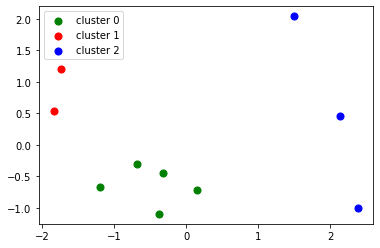

In [110]:
# plotting the 3 clusters
plt.scatter(lift_table_pca[km_pred == 0, 0],
            lift_table_pca[km_pred == 0, 1],
            s=50,
            c='green',
            #marker='s',
            label='cluster 0')

plt.scatter(lift_table_pca[km_pred == 1, 0],
            lift_table_pca[km_pred == 1, 1],
            s=50,
            c='red',
            #marker='o',
            label='cluster 1')

plt.scatter(lift_table_pca[km_pred == 2, 0],
            lift_table_pca[km_pred == 2, 1],
            s=50,
            c='blue',
            #marker='v',
            label='cluster 2')

plt.legend()
plt.show()

The method we used for conducting our lift similarity analysis began with calculating lift values for 10 games against the top four attributes found in our word frequency analysis. We then standardized the lift values and performed Principal Component Analysis to reduce our dimenionality from four to two in order to allow for the plot you see above. We then used K Means Clustering to find the most similar games based on PCA values. Overall, K Means Clustering was the method we used to determine similarity based on lift values - the other steps were more or less preprocessing for K Means. 

If we were to choose HorizonZeroDawn as our game of choice, the most similar game would be AsterigosCurseoftheStars based on our K Means clustering analysis. These games are the only two that are part of cluster 1 which indicates their similarity when compared to the rest of the games.

When looking at the lift table, we can see that these games have similar lift values in each category. Qualitatively, upon research, both of these games are Action-RPGs, so it makes sense that they are clustered together.